In [36]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [39]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [40]:
series = pd.read_csv('weekly-closings-of-the-dowjones-.csv').dropna().values[:, 1]

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [41]:
from arch import arch_model

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [43]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


aic: 1416.27670 | order: (2, 2, 3)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


Results of Dickey-Fuller Test:
Test Statistic                -1.184571e+01
p-value                        7.408188e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


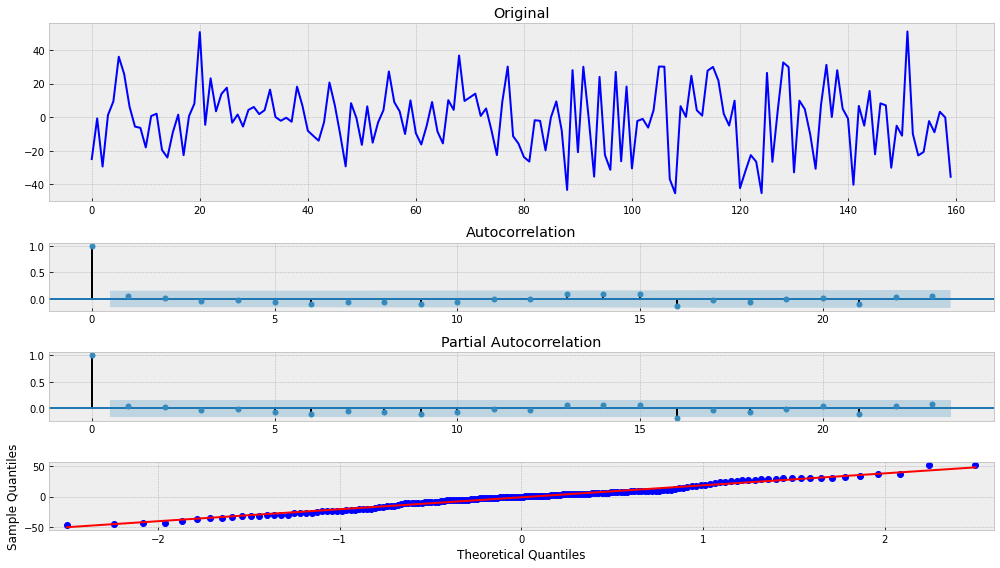

In [44]:
tsplot(mdl.resid)

Применим GARCH

In [45]:
series = series[1:] - series[:-1]

In [46]:
series = series.astype(float)

In [47]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 2
o_ = 2
q_ = 3

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -698.935
Distribution:      Standardized Student's t   AIC:                           1417.87
Method:                  Maximum Likelihood   BIC:                           1448.68
                                              No. Observations:                  161
Date:                      Thu, Jan 28 2021   Df Residuals:                      151
Time:                              19:23:35   Df Model:                           10
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


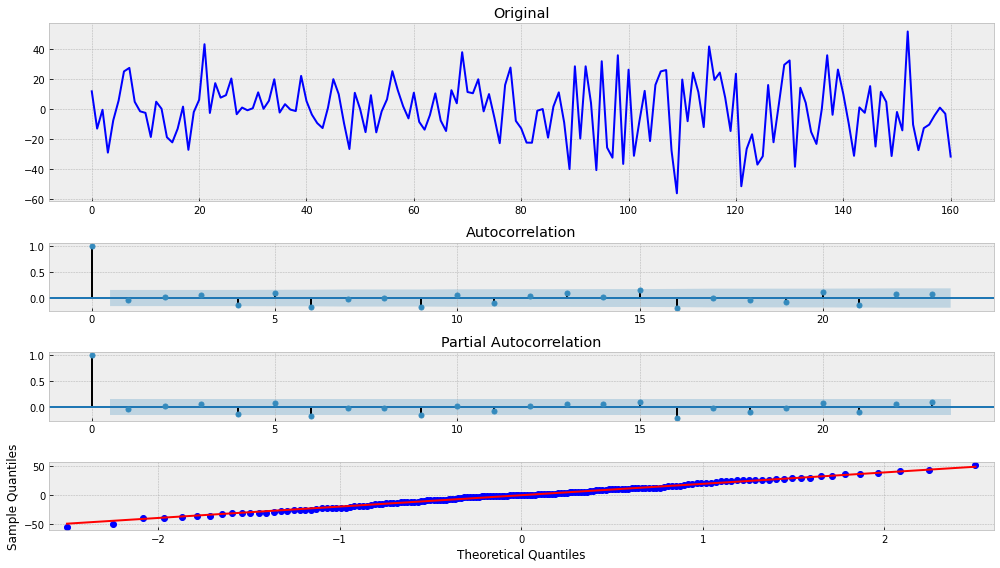

In [48]:
tsplot(res.resid)

## По простому

In [49]:
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

In [52]:
s = pd.DataFrame(series['Close'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s.loc[:, f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80,890.19
11,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80
12,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51
13,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78
14,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43


In [58]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [63]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=5, test_size=0.3)

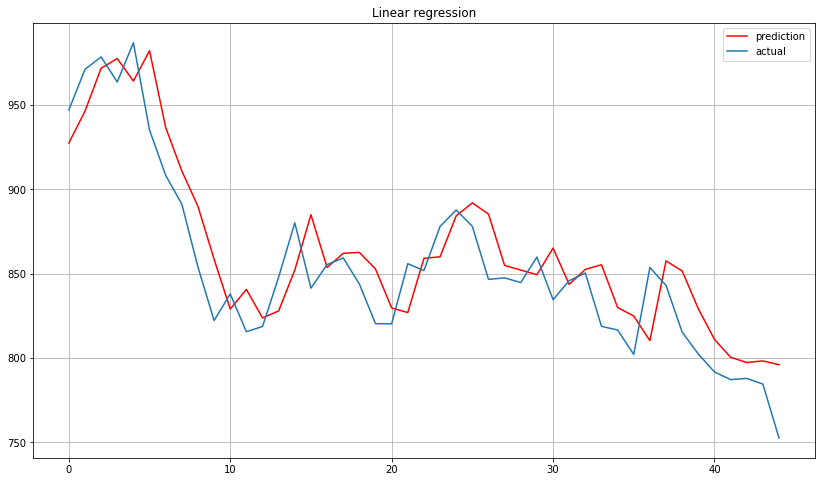

In [64]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016